In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

from utils_data import import_artificial

pd.set_option('display.max_colwidth', None)
from utils import printable


In [4]:
df_discretized = import_artificial(input_dir="./data", use_stored=True, store_data=True)

Loading artificial dataset


In [5]:
df_discretized.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'class', 'predicted'], dtype='object')

# Divergence analysis

In [6]:
min_support = 0.001
min_support_count = min_support*len(df_discretized)
min_support_count

50.0

In [7]:
import resource

def limit_memory(max_mem_mb):
    """Limit memory usage of the current notebook process."""
    soft, hard = max_mem_mb * 1024 * 1024, max_mem_mb * 1024 * 1024
    resource.setrlimit(resource.RLIMIT_AS, (soft, hard))

# Example: Limit the notebook to 2 GB of memory
limit_memory(32*1024)

## FPR

In [8]:
from divexplorer.outcomes import get_false_positive_rate_outcome

target_col = 'fp'

df_discretized_analyze = df_discretized.copy()

df_discretized_analyze[target_col] =  get_false_positive_rate_outcome(df_discretized_analyze['class'].values, df_discretized_analyze['predicted'].values)

df_discretized_analyze.drop(columns=["class", "predicted"], inplace=True)

type_outcome = 'boolean'

In [9]:
from divexplorer import DivergenceExplorer

fp_diver = DivergenceExplorer(df_discretized_analyze)

In [10]:
import time
try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, boolean_outcomes=[target_col])
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 3.284219264984131 seconds ---


In [11]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

In [12]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)

In [13]:
import time
try:
    
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.40227603912353516 seconds ---


In [14]:
subgroups_print = patterns[cols].sort_values(by=f"{target_col}_div", ascending=False).head(3).copy()
subgroups_print = printable(subgroups_print, target_col)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,fp,fp_div,fp_t
242,"a=1, b=1, c=1",0.127,1.00,0.86,500.0
557,"a=0, b=0, c=0",0.125,1.00,0.86,500.0
57582,"a=0, c=0, d=1, e=1, f=0, g=1, h=1, i=1, j=0",0.002,0.52,0.37,5.8


\begin{tabular}{lrrrr}
\toprule
                                    itemset &  support &   fp &  fp\_div &  fp\_t \\
\midrule
                              a=1, b=1, c=1 &    0.127 & 1.00 &    0.86 & 500.0 \\
                              a=0, b=0, c=0 &    0.125 & 1.00 &    0.86 & 500.0 \\
a=0, c=0, d=1, e=1, f=0, g=1, h=1, i=1, j=0 &    0.002 & 0.52 &    0.37 &   5.8 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_594466/987044874.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(subgroups_print.to_latex(index=False))


In [15]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col]

0.14432187485695977

### Global

In [16]:
gsv = fp_details.global_shapley_value()

In [17]:
individual_divergence = fp_details.patterns.loc[fp_details.patterns['length']==1][['itemset', f'{target_col}_div']]\
    .set_index('itemset').to_dict()[f'{target_col}_div']

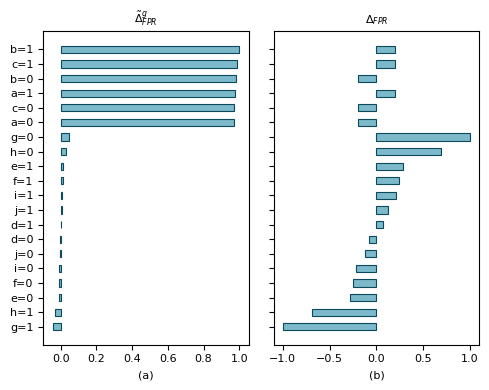

In [18]:
from utils import plot_comparison_ShapleyValues, normalize_max

K=25
topK_global = {k:v for k,v in gsv.items() if k in sorted(gsv, key=lambda x: abs(gsv[x]))[::-1][:K]}
topK_indiv = {k:v for k,v in individual_divergence.items() if k in topK_global.keys()}

plot_comparison_ShapleyValues(normalize_max(topK_global),
                      normalize_max(topK_indiv),
                     title=["$\\tilde{\\Delta}^g_{FPR}$", "$\\Delta_{FPR}$"], \
                      labelsize=8, height=0.5, size_fig=(5,4),\
                     subcaption=True,
                     save_fig=True, 
                     name_fig='./artificial_10_FPR_shap_gl_compare_0.01.pdf')


# SliceLine

In [19]:
attributes = df_discretized.columns.tolist()
attributes.remove('class')
attributes.remove('predicted')
attributes

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [20]:
errors = (df_discretized['class']!=df_discretized['predicted']).astype(int)

errors = (df_discretized_analyze['fp']==1).astype(int)

In [21]:
from sliceline.slicefinder import Slicefinder

start_time = time.time()

try:
    sl = Slicefinder(
        alpha = 0.95,
        k = 100, #df_discretized_analyze[attributes].shape[0],
        max_l = 3,  #df_discretized_analyze[attributes].shape[1],
        min_sup = round(min_support_count),
        verbose = False
    )

    sl.fit(df_discretized_analyze[attributes], errors)

    print("--- %s seconds ---" % (time.time() - start_time))


except MemoryError:
    print("Memory limit exceeded!")

/home/epastor/miniconda3/envs/mainexp/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


--- 1.632751226425171 seconds ---


In [22]:
sl_subgroups_df = pd.DataFrame(sl.top_slices_, columns=sl.feature_names_in_, index=sl.get_feature_names_out())

In [23]:
from sliceline.slicefinder import Slicefinder

start_time = time.time()

try:
    sl = Slicefinder(
        k=100,
        alpha = 0.95,
        max_l = 9,
        verbose = False
    )

    sl.fit(df_discretized_analyze[attributes], errors)

    print("--- %s seconds ---" % (time.time() - start_time))


except MemoryError:
    print("Memory limit exceeded!")

/home/epastor/miniconda3/envs/mainexp/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


--- 82.32150316238403 seconds ---


In [24]:
sl_subgroups_df = pd.DataFrame(sl.top_slices_, columns=sl.feature_names_in_, index=sl.get_feature_names_out())
sl_subgroups_df

,a,b,c,d,e,f,g,h,i,j
slice_0,0,0,0,None,None,None,None,None,None,None
slice_1,1,1,1,None,None,None,None,None,None,None
slice_2,0,0,0,None,None,None,None,1,None,None
slice_3,0,0,0,None,None,None,1,None,None,None
slice_4,0,0,0,1,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
slice_95,1,1,1,1,0,None,None,None,None,None
slice_96,0,0,0,None,None,0,1,None,None,None
slice_97,0,0,0,1,None,1,None,None,None,None
slice_98,0,0,0,None,None,None,None,1,None,1


In [25]:
# Slice Finder

In [26]:
from sklearn import model_selection
import numpy as np
np.random.seed(1)

df_train, df_test, labels_train, labels_test = model_selection.train_test_split(df_discretized, df_discretized['predicted'], train_size=0.80)

In [27]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.preprocessing import OneHotEncoder



encoder = OneHotEncoder(sparse_output=False)  # sparse=False → return NumPy array
encoded_train = encoder.fit_transform(df_train[attributes])
encoded_test = encoder.transform(df_test[attributes])


df_discretized_ohe_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(df_discretized[attributes].columns), index=df_train.index)
df_discretized_ohe_test = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(df_discretized[attributes].columns), index=df_test.index)

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(df_discretized_ohe_train.values, labels_train);

In [29]:
import random
random.seed(42)

df_test_modified = df_test.copy()
df_test_modified["class"] = clf.predict(df_discretized_ohe_test.values)
df_test_modified["predicted"] = df_test_modified["class"].values
id_mod = df_test_modified.loc[(df_test_modified["a"]==df_test_modified["b"]) & (df_test_modified["a"]==df_test_modified["c"])].index
id_mod = random.sample(list(id_mod), int(len(id_mod)/2))
df_test_modified.loc[id_mod, "class"] = 0

## DivExplorer

In [30]:
from divexplorer.outcomes import get_false_positive_rate_outcome

target_col = 'fp'

df_discretized_analyze = df_test_modified.copy()

df_discretized_analyze[target_col] =  get_false_positive_rate_outcome(df_discretized_analyze['class'].values, df_discretized_analyze['predicted'].values)

df_discretized_analyze.drop(columns=["class", "predicted"], inplace=True)

type_outcome = 'boolean'

In [31]:
from divexplorer import DivergenceExplorer

fp_diver = DivergenceExplorer(df_discretized_analyze)

In [32]:
import time
try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, boolean_outcomes=[target_col])
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 3.3003251552581787 seconds ---


In [33]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

In [34]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)

In [35]:
import time
try:
    
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0.1)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.49326539039611816 seconds ---


In [36]:
patterns[cols].sort_values(by=f"{target_col}_div", ascending=False)

,itemset,support,fp,fp_div,fp_t
362,"(b=0, c=0, a=0)",0.1281,1.000000,0.850029,205.767075
206,"(b=1, c=1, a=1)",0.1328,1.000000,0.850029,205.854406
57525,"(c=1, a=1, h=0, j=1, e=0, f=0, d=0, g=0, i=0)",0.0014,0.750000,0.600029,3.978706
56550,"(f=1, h=0, g=0, j=1, e=0, c=0, d=0, a=0, i=0)",0.0017,0.727273,0.577301,4.393911
51610,"(h=1, f=1, e=1, c=0, j=0, d=0, g=1, a=0)",0.0031,0.695652,0.545681,5.787761
57284,"(h=0, b=0, j=1, e=1, c=0, f=0, d=0, g=1, i=0)",0.0015,0.666667,0.516695,3.500694
47885,"(h=1, j=0, b=0, e=0, c=0, i=1, f=0, g=0)",0.0038,0.640000,0.490029,5.250438
48857,"(a=1, b=1, e=1, f=0, j=0, d=0, g=0, i=0)",0.0036,0.615385,0.465413,5.035612
52798,"(h=1, f=1, b=0, j=1, e=0, c=0, i=1, d=0)",0.0027,0.600000,0.450029,4.297234
40949,"(h=1, f=1, e=1, c=0, j=0, d=0, a=0)",0.0062,0.568182,0.418211,5.733481


In [37]:
subgroups_print = patterns[cols].sort_values(by=f"{target_col}_div", ascending=False).head(3).copy()
subgroups_print = printable(subgroups_print, target_col)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,fp,fp_div,fp_t
362,"a=0, b=0, c=0",0.128,1.00,0.85,205.8
206,"a=1, b=1, c=1",0.133,1.00,0.85,205.9
57525,"a=1, c=1, d=0, e=0, f=0, g=0, h=0, i=0, j=1",0.001,0.75,0.60,4.0


\begin{tabular}{lrrrr}
\toprule
                                    itemset &  support &   fp &  fp\_div &  fp\_t \\
\midrule
                              a=0, b=0, c=0 &    0.128 & 1.00 &    0.85 & 205.8 \\
                              a=1, b=1, c=1 &    0.133 & 1.00 &    0.85 & 205.9 \\
a=1, c=1, d=0, e=0, f=0, g=0, h=0, i=0, j=1 &    0.001 & 0.75 &    0.60 &   4.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_594466/987044874.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(subgroups_print.to_latex(index=False))


In [38]:
df_discretized_ohe_test

,a_0,a_1,b_0,b_1,c_0,c_1,d_0,d_1,e_0,e_1,f_0,f_1,g_0,g_1,h_0,h_1,i_0,i_1,j_0,j_1
26247,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
35067,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
34590,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
16668,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
12196,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49858,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
19849,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
46899,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
28256,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
import functools

y_predict_prob_test = clf.predict_proba(df_discretized_ohe_test)

modified_class = df_test_modified["class"]
modified_predicted = df_test_modified["predicted"]



from slice_finder import SliceFinder
max_workers=1

n_bin=10
degree=3
sf = SliceFinder(clf, (df_discretized_ohe_test, modified_class))

recommendations = sf.find_slice(degree=degree, max_workers=1, epsilon=1, alpha=1)


/home/epastor/miniconda3/envs/mainexp/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


degree 1
crossing
effect size filtering
degree 2
crossing
effect size filtering
degree 3
crossing
effect size filtering


In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names"
)

In [ ]:
recommendations = sf.find_slice(k=3, epsilon=0.8, degree=2)

In [ ]:
def getSliceFrozenset(s):
    slice_i = []
    for k, v in list(s.filters.items()):
        values = ''
        for _v in v:
            values += '%s'%(_v)
        #if k in encoders:
        #    le = encoders[k]
        #    for v_ in v:
        #        values += '%s'%(le.inverse_transform(v_)[0])
        slice_i.append('%s=%s'%(k, values))
    return frozenset(slice_i)

In [ ]:
rows=[]
for s in recommendations:
    rows.append([getSliceFrozenset(s), s.metric, s.effect_size])
df_slices=pd.DataFrame(rows, columns=["slice", "log_loss", "effect_size"])
df_slices